In [2]:
#csvファイルを読み込む
import pandas as pd

# ファイルパス（適宜変更してください）
file_path = "sweden_energy_transition.csv"

# 読み込み
df = pd.read_csv(file_path)

# 先頭5行を確認
print(df.head())

# データの概要
print(df.info())



   year  draught \nanimal \nenergy  human \nenergy  humene \nfor \nwork  \
0  1800                       12.6            9.29                 1.56   
1  1801                       12.7            9.33                 1.57   
2  1802                       12.8            9.40                 1.59   
3  1803                       12.9            9.47                 1.60   
4  1804                       13.0            9.54                 1.62   

   humene \nfor \nfinal \nconsump \n-tion   total \nanimate \nenergy  \
0                                     7.73                     21.89   
1                                     7.75                     22.03   
2                                     7.81                     22.20   
3                                     7.87                     22.37   
4                                     7.92                     22.54   

   fire-\nwood \nhouse-\nholds  fire-\nwood \nindustry   \
0                        75.90                     7.62  

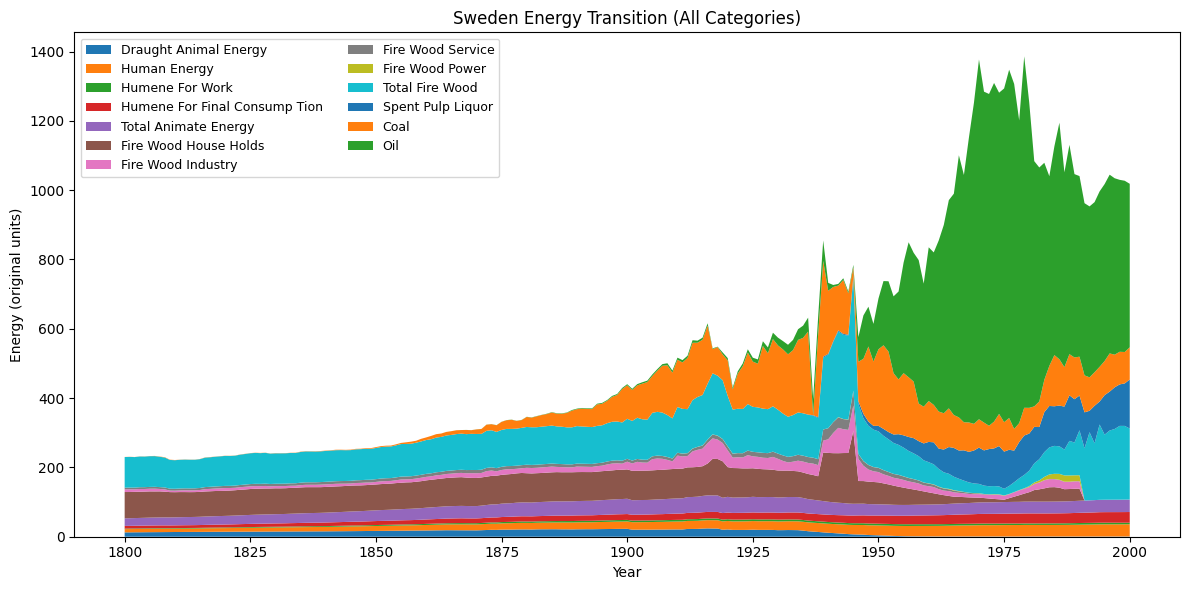

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === 設定 ===
file_path = "sweden_energy_transition.csv"  # 実際のCSVファイル名に合わせる
USE_SHARES = False  # Trueにすると各年100%で割合の積み上げ

# === ヘルパー ===
def clean_col(s: str) -> str:
    s = re.sub(r"[\r\n]+", " ", str(s)).strip()
    s = re.sub(r"\s*-\s*", "_", s)
    s = re.sub(r"\s+", "_", s)
    return s.lower()

# === 読み込み ===
df_raw = pd.read_csv(file_path, header=None)
# 最初に4桁の年が出る行をデータ開始とみなす
year_row_idx = df_raw.apply(lambda r: bool(re.match(r"^\s*\d{4}\s*$", str(r.iloc[0]))), axis=1).idxmax()
header_idx = max(0, year_row_idx - 1)
cols = df_raw.iloc[header_idx].map(clean_col).tolist()
df = df_raw.iloc[year_row_idx:].copy()
df.columns = cols[: len(df.columns)]

# 年列を特定
year_col = None
for c in df.columns:
    if "year" in c:
        year_col = c
        break
if year_col is None:
    year_col = df.columns[0]

# 数値化
df[year_col] = pd.to_numeric(df[year_col], errors="coerce")
for c in df.columns:
    if c != year_col:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[year_col]).sort_values(year_col).reset_index(drop=True)

# === 全列使用 ===
energy_cols = [c for c in df.columns if c != year_col]
Y = df[energy_cols].fillna(0).copy()

# 割合にしたい場合
if USE_SHARES:
    row_sum = Y.sum(axis=1).replace(0, np.nan)
    Y = Y.div(row_sum, axis=0) * 100.0
    y_label = "Share (%)"
else:
    y_label = "Energy (original units)"

labels = [re.sub(r"_", " ", c).title() for c in energy_cols]

# === 積み上げグラフ ===
plt.figure(figsize=(12, 6))
plt.stackplot(df[year_col], *[Y[c] for c in energy_cols], labels=labels)
plt.legend(loc="upper left", ncol=2, fontsize=9)
plt.xlabel("Year")
plt.ylabel(y_label)
plt.title("Sweden Energy Transition (All Categories)")
plt.tight_layout()
plt.show()


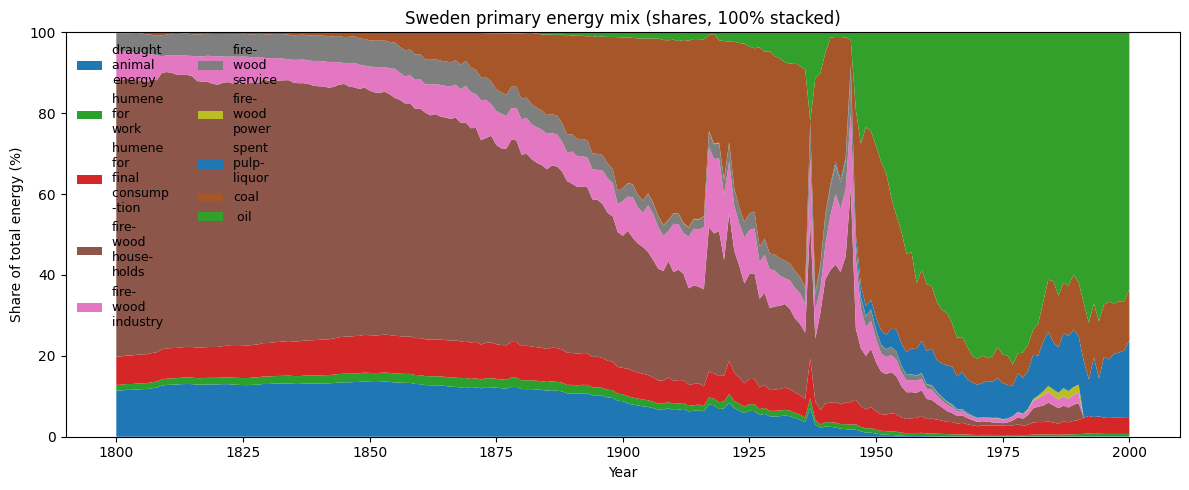

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

file_path = "sweden_energy_transition.csv"

# ---- load (ヘッダはそのまま) ----
df = pd.read_csv(file_path)
year_col = df.columns[0]
df[year_col] = pd.to_numeric(df[year_col], errors="coerce")
for c in df.columns[1:]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=[year_col]).sort_values(year_col).reset_index(drop=True).fillna(0)

# ---- 正規化ヘルパ（照合専用・列名は変更しない） ----
def norm(s: str) -> str:
    s = re.sub(r"\s+", " ", str(s).strip().lower())
    s = s.replace("liqour", "liquor").replace("liquour", "liquor")  # スペル揺れ補正（照合のみ）
    return s

raw_cols = [c for c in df.columns if c != year_col]
norm_map = {c: norm(c) for c in raw_cols}

def find_col(*keywords):
    """キーワード全部を含む列を返す（最初に見つかった1本）。"""
    keys = [norm(k) for k in keywords]
    for raw, nm in norm_map.items():
        if all(k in nm for k in keys):
            return raw
    return None

# ---- 二重計上を避ける“基礎系列”を自動特定 ----
c_draught = find_col("draught", "animal", "energy")
c_work    = find_col("hum", "work")                          # humene/human 両対応
c_final   = find_col("hum", "final", "consump")              # consump tion / consumption 両対応
c_fhh     = find_col("fire", "wood", "house")                # house holds 両対応
c_find    = find_col("fire", "wood", "industry")
c_fserv   = find_col("fire", "wood", "service")
c_fpow    = find_col("fire", "wood", "power")
c_spl     = find_col("spent", "pulp", "liquor")
c_coal    = find_col("coal")
c_oil     = find_col("oil")

energy_cols = [c for c in [c_draught, c_work, c_final, c_fhh, c_find, c_fserv, c_fpow, c_spl, c_coal, c_oil] if c]

# ---- 保険：もし上で1本も見つからなければ、合計列っぽいものを除いて全部使う ----
if not energy_cols:
    energy_cols = [c for c in raw_cols if not re.search(r"(?i)\btotal\b", c)]
    # Human Energy / Total Animate Energy / Total Fire Wood を個別除外（あれば）
    energy_cols = [c for c in energy_cols if norm_map[c] not in
                   {norm("human energy"), norm("total animate energy"), norm("total fire wood")}]

# ---- 100%化 ----
Y = df[energy_cols]
row_sum = Y.sum(axis=1).replace(0, np.nan)
share = Y.div(row_sum, axis=0) * 100.0

# ---- 配色（前回と同じ）を“カテゴリ→実際の列”に対応づけ ----
base_colors = {
    "draught": "#1f77b4",
    "human work": "#2ca02c",
    "human final": "#d62728",
    "fire wood households": "#8c564b",
    "fire wood industry": "#e377c2",
    "fire wood service": "#7f7f7f",
    "fire wood power": "#bcbd22",
    "spent pulp liquor": "#1f78b4",
    "coal": "#a65628",
    "oil": "#33a02c",
}
col2color = {}
if c_draught: col2color[c_draught] = base_colors["draught"]
if c_work:    col2color[c_work]    = base_colors["human work"]
if c_final:   col2color[c_final]   = base_colors["human final"]
if c_fhh:     col2color[c_fhh]     = base_colors["fire wood households"]
if c_find:    col2color[c_find]    = base_colors["fire wood industry"]
if c_fserv:   col2color[c_fserv]   = base_colors["fire wood service"]
if c_fpow:    col2color[c_fpow]    = base_colors["fire wood power"]
if c_spl:     col2color[c_spl]     = base_colors["spent pulp liquor"]
if c_coal:    col2color[c_coal]    = base_colors["coal"]
if c_oil:     col2color[c_oil]     = base_colors["oil"]

# 未指定の列（fallback）は灰色
colors = [col2color.get(c, "#cccccc") for c in energy_cols]

# ---- プロット ----
plt.figure(figsize=(12, 5))
plt.stackplot(df[year_col], *[share[c] for c in energy_cols],
              labels=energy_cols, colors=colors)
plt.xlabel("Year"); plt.ylabel("Share of total energy (%)")
plt.title("Sweden primary energy mix (shares, 100% stacked)")
plt.ylim(0, 100)
plt.legend(loc="upper left", ncol=2, fontsize=9, frameon=False)
plt.tight_layout(); plt.show()


In [5]:
print(df.columns.tolist())


['year', 'draught \nanimal \nenergy', 'human \nenergy', 'humene \nfor \nwork', 'humene \nfor \nfinal \nconsump \n-tion ', 'total \nanimate \nenergy', 'fire-\nwood \nhouse-\nholds', 'fire-\nwood \nindustry ', 'fire-\nwood \nservice', 'fire-\nwood \npower', 'total \nfire-\nwood ', 'spent \npulp- \nliquor ', 'coal', ' oil']


# modern energy contains oil coal pulp liquor, and fire wood power

Normalization reference year (max modern ratio): 1975
Max normalized value: 1.000
Data used for fitting: 1800–1975
Number of points (raw): 176
Saved Sweden_modern_energy_rate.npy  (normalized)
Shape: (176, 2)

=== Sweden: Fitted parameters (raw, normalized) ===
a = 1.2  (SE=0.138, 95% CI [0.928375, 1.47162])
b = 468.994  (SE=179, 95% CI [116.32, 821.667])
c = 0.0417621  (SE=0.00408, 95% CI [0.0337103, 0.0498139])

Standard logistic form for Sweden:
  k  = 0.041762
  x* = 1947.28  # 50% modern-energy year (inflection)


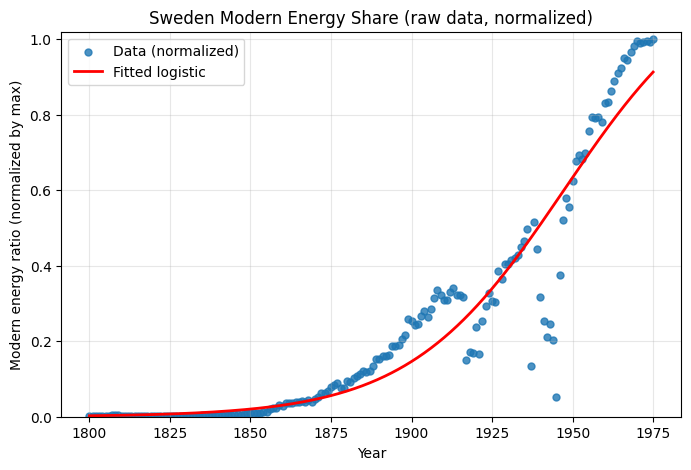

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t

# 前提：df はすでに Sweden のデータが入っている
# df.columns は以下の通り：
# ['year', 'draught \nanimal \nenergy', 'human \nenergy',
#  'humene \nfor \nwork', 'humene \nfor \nfinal \nconsump \n-tion ',
#  'total \nanimate \nenergy', 'fire-\nwood \nhouse-\nholds',
#  'fire-\nwood \nindustry ', 'fire-\nwood \nservice',
#  'fire-\nwood \npower', 'total \nfire-\nwood ',
#  'spent \npulp- \nliquor ', 'coal', ' oil']

year_col = "year"   # 年列の名前

# =========================
# 1) modern energy rate の計算
# =========================

modern_energy_rate = []

for i in range(len(df)):
    row = df.iloc[i]

    # ★列名は df.columns の文字列そのまま使う★
    modern_energy = (
        row['coal'] +
        row[' oil'] +                       # ← 先頭スペースあり
        row['spent \npulp- \nliquor '] +    # ← 改行＋末尾スペースあり
        row['fire-\nwood \npower']          # ← 改行入り
    )

    # 総エネルギー：1列目以降（year を除く全部）を合計
    total_energy = row[df.columns[1:]].sum()

    if total_energy == 0 or np.isnan(total_energy):
        rate = np.nan
    else:
        rate = modern_energy / total_energy

    modern_energy_rate.append(rate)

modern_energy_rate = np.array(modern_energy_rate, dtype=float)
years = df[year_col].to_numpy(dtype=float)

# NaN を除外
mask = ~np.isnan(modern_energy_rate)
years = years[mask]
vals_raw = modern_energy_rate[mask]

# =========================
# 2) 最大値で正規化（最終的に max = 1）
# =========================

EPS_LOW, EPS_HIGH = 1e-4, 1 - 1e-4

max_val = np.nanmax(vals_raw)
vals_norm = vals_raw / max_val
vals_norm = np.clip(vals_norm, EPS_LOW, EPS_HIGH)

imax = np.nanargmax(vals_norm)
year_max = years[imax]
val_at_max = vals_norm[imax]

# 最大年までだけ使う（上昇期＋飽和直前）
mask_fit = years <= year_max
years_fit = years[mask_fit]
vals_fit  = vals_norm[mask_fit]

print(f"Normalization reference year (max modern ratio): {year_max:.0f}")
print(f"Max normalized value: {val_at_max:.3f}")
print(f"Data used for fitting: {years_fit.min():.0f}–{years_fit.max():.0f}")
print(f"Number of points (raw): {len(years_fit)}")

# =========================
# 3) npy に保存
# =========================

# 正規化前も残したければ raw も別ファイルに
np.save("Sweden_modern_energy_rate_raw.npy",
        np.column_stack((years, vals_raw)))

# 解析用：年＋正規化済み ratio
arr = np.column_stack((years_fit, vals_fit))
np.save("Sweden_modern_energy_rate.npy", arr)
print("Saved Sweden_modern_energy_rate.npy  (normalized)")
print(f"Shape: {arr.shape}")

# =========================
# 4) ロジスティック関数でフィット（生データそのまま）
# =========================

def model_func(x, a, b, c):
    """
    f(x) = a / (1 + b * exp(-c * (x - x0)))
    x0 は数値安定化のため x の最小値
    """
    x = np.asarray(x, dtype=float)
    x0 = x.min()
    return a / (1.0 + b * np.exp(-c * (x - x0)))

p0 = [1.0, 1.0, 0.03]   # 正規化済みなので a ≈ 1
bounds = ([0.5, 0.0, 1e-4], [1.2, 1e6, 1.0])

popt, pcov = curve_fit(
    model_func,
    years_fit,
    vals_fit,
    p0=p0,
    bounds=bounds,
    maxfev=200000,
)
a, b, c = popt
perr = np.sqrt(np.diag(pcov))

# =========================
# 5) 標準ロジスティック形（k, x*）に変換
# =========================

x0 = years_fit.min()
k = c
lnb = np.log(b)
x_star = x0 + lnb / c   # 50% 転換年（inflection）

ALPHA = 0.05
dof = max(len(years_fit) - len(popt), 1)
tval = t.ppf(1 - ALPHA/2, dof)

print("\n=== Sweden: Fitted parameters (raw, normalized) ===")
for name, val, se in zip(["a", "b", "c"], popt, perr):
    ci_low  = val - tval * se
    ci_high = val + tval * se
    print(f"{name} = {val:.6g}  (SE={se:.3g}, 95% CI [{ci_low:.6g}, {ci_high:.6g}])")

print(f"\nStandard logistic form for Sweden:")
print(f"  k  = {k:.6f}")
print(f"  x* = {x_star:.2f}  # 50% modern-energy year (inflection)")

# =========================
# 6) プロット
# =========================

t_grid = np.linspace(years_fit.min(), year_max, 600)
yhat = model_func(t_grid, *popt)

plt.figure(figsize=(8, 5))
plt.scatter(years_fit, vals_fit, s=25, alpha=0.8, label="Data (normalized)")
plt.plot(t_grid, yhat, "r-", lw=2, label="Fitted logistic")
plt.xlabel("Year")
plt.ylabel("Modern energy ratio (normalized by max)")
plt.title("Sweden Modern Energy Share (raw data, normalized)")
plt.ylim(0, 1.02)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


# Remove former half where the values are 0

Detected start year: 1857 (ratio>0.02)
Fitting range: 1857–1975

=== Sweden: Fitted parameters (cut, normalized) ===
a = 1.2  (SE=0.174, 95% CI [0.855699, 1.5443])
b = 42.4918  (SE=9.23, 95% CI [24.214, 60.7696])
c = 0.0415309  (SE=0.00518, 95% CI [0.0312646, 0.0517972])

k = 0.041531,  x* = 1947.28


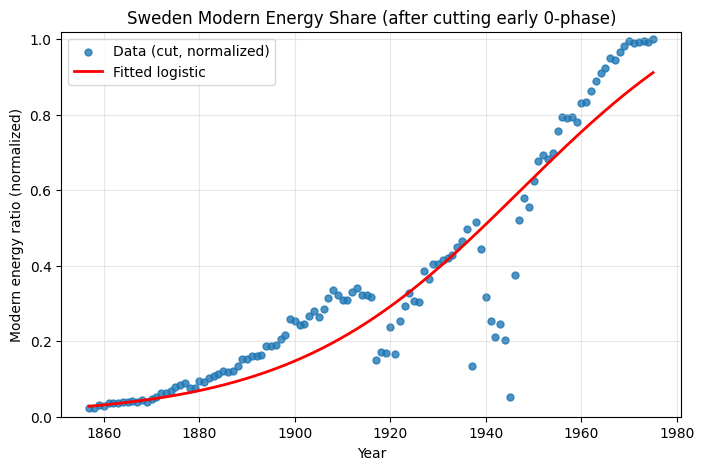

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t

# --- 前提 ---
# arr = np.load("Sweden_modern_energy_rate.npy")
# または前のコードの years_fit, vals_fit を使用
# years_fit = 年の配列
# vals_fit = 正規化済みモダンエネルギー比

EPS_LOW, EPS_HIGH = 1e-4, 1-1e-4
ALPHA = 0.05

# --- 1) 上昇期の開始点を自動検出 ---
# 「modern energy ratio > 0.02（2%）」あたりを起点とする
THRESH = 0.02
mask_start = vals_fit > THRESH
start_idx = np.argmax(mask_start)  # 最初に2%を超えた位置
start_year = years_fit[start_idx]

years_cut = years_fit[start_idx:]
vals_cut  = vals_fit[start_idx:]

print(f"Detected start year: {start_year:.0f} (ratio>{THRESH})")
print(f"Fitting range: {years_cut.min():.0f}–{years_cut.max():.0f}")

# --- 2) ロジスティック関数でフィット ---
def model_func(x, a, b, c):
    x0 = x.min()
    return a / (1.0 + b * np.exp(-c * (x - x0)))

p0 = [1.0, 1.0, 0.03]
bounds = ([0.5, 0.0, 1e-4], [1.2, 1e6, 1.0])

popt, pcov = curve_fit(
    model_func, years_cut, vals_cut,
    p0=p0, bounds=bounds, maxfev=200000
)
a, b, c = popt
perr = np.sqrt(np.diag(pcov))

# --- 3) 標準ロジスティック形のパラメータ変換 ---
x0 = years_cut.min()
k = c
lnb = np.log(b)
x_star = x0 + lnb / c

dof = max(len(years_cut) - len(popt), 1)
tval = t.ppf(1 - ALPHA/2, dof)

print("\n=== Sweden: Fitted parameters (cut, normalized) ===")
for name, val, se in zip(["a","b","c"], popt, perr):
    ci_low  = val - tval * se
    ci_high = val + tval * se
    print(f"{name} = {val:.6g}  (SE={se:.3g}, 95% CI [{ci_low:.6g}, {ci_high:.6g}])")
print(f"\nk = {k:.6f},  x* = {x_star:.2f}")

# --- 4) プロット ---
t_grid = np.linspace(years_cut.min(), years_cut.max(), 600)
yhat = model_func(t_grid, *popt)

plt.figure(figsize=(8,5))
plt.scatter(years_cut, vals_cut, s=25, alpha=0.8, label="Data (cut, normalized)")
plt.plot(t_grid, yhat, "r-", lw=2, label="Fitted logistic")
plt.xlabel("Year")
plt.ylabel("Modern energy ratio (normalized)")
plt.title("Sweden Modern Energy Share (after cutting early 0-phase)")
plt.ylim(0, 1.02)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


# remove war period data from fitting process


Total points after early-cut: 119
Used for fit (excluding wars): 99
Fit range: 1857–1975

=== Sweden: Fitted parameters (wars excluded) ===
a = 1.2  (SE=0.0895, 95% CI [1.02233, 1.37767])
b = 32.0713  (SE=3.77, 95% CI [24.5924, 39.5502])
c = 0.0407334  (SE=0.00294, 95% CI [0.0348911, 0.0465756])

k = 0.040733,  x* = 1942.14


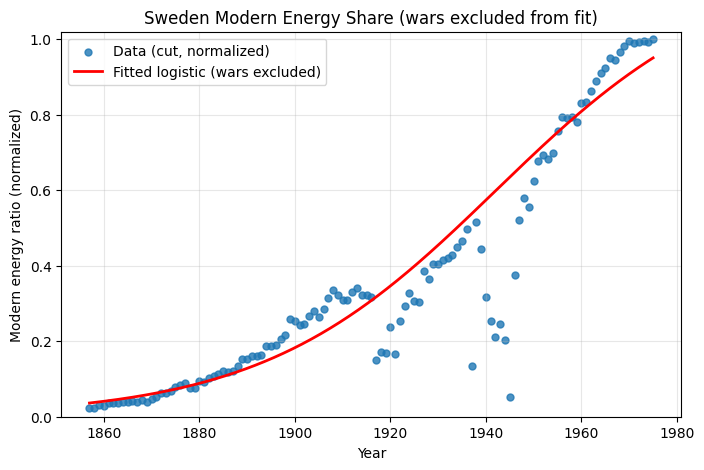

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t

# years_cut, vals_cut がすでにある前提
# （0期を THRESH で切った後の years / normalized ratio）

EPS_LOW, EPS_HIGH = 1e-4, 1-1e-4
ALPHA = 0.05

years_all = years_cut
vals_all  = vals_cut

# --- 1) 戦争期間をマスクして除外してフィット ---

# 第一次世界大戦 1914–1918, 第二次世界大戦 1939–1945 として,開戦後10年間を除外
war_mask = (
    ((years_all >= 1914) & (years_all <= 1923)) |
    ((years_all >= 1939) & (years_all <= 1948))
)

# フィットに使うのは戦争期間以外
fit_mask = ~war_mask
years_fit = years_all[fit_mask]
vals_fit  = vals_all[fit_mask]

print(f"Total points after early-cut: {len(years_all)}")
print(f"Used for fit (excluding wars): {len(years_fit)}")
print(f"Fit range: {years_fit.min():.0f}–{years_fit.max():.0f}")

# --- 2) ロジスティック関数でフィット ---
def model_func(x, a, b, c):
    x = np.asarray(x, dtype=float)
    x0 = x.min()
    return a / (1.0 + b * np.exp(-c * (x - x0)))

p0 = [1.0, 1.0, 0.03]
bounds = ([0.5, 0.0, 1e-4], [1.2, 1e6, 1.0])

popt, pcov = curve_fit(
    model_func,
    years_fit,
    vals_fit,
    p0=p0,
    bounds=bounds,
    maxfev=200000
)
a, b, c = popt
perr = np.sqrt(np.diag(pcov))

# 標準ロジスティック形（k, x*）
x0 = years_fit.min()
k = c
lnb = np.log(b)
x_star = x0 + lnb / c

dof = max(len(years_fit) - len(popt), 1)
tval = t.ppf(1 - ALPHA/2, dof)

print("\n=== Sweden: Fitted parameters (wars excluded) ===")
for name, val, se in zip(["a","b","c"], popt, perr):
    ci_low  = val - tval * se
    ci_high = val + tval * se
    print(f"{name} = {val:.6g}  (SE={se:.3g}, 95% CI [{ci_low:.6g}, {ci_high:.6g}])")
print(f"\nk = {k:.6f},  x* = {x_star:.2f}")

# --- 3) プロット（データは全部、フィットは戦争年抜き） ---
t_grid = np.linspace(years_all.min(), years_all.max(), 600)
yhat = model_func(t_grid, *popt)

plt.figure(figsize=(8,5))
plt.scatter(years_all, vals_all, s=25, alpha=0.8, label="Data (cut, normalized)")
plt.plot(t_grid, yhat, "r-", lw=2, label="Fitted logistic (wars excluded)")
plt.xlabel("Year")
plt.ylabel("Modern energy ratio (normalized)")
plt.title("Sweden Modern Energy Share (wars excluded from fit)")
plt.ylim(0, 1.02)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


# fix a=1 and refit(おまけ)

# remove initial period and war period

Total points after early-cut: 119
Used for fit (excluding wars): 99
Fit range: 1857–1975

=== Sweden: Fitted parameters (a=1 fixed, wars excluded) ===
b = 34.2141  (SE=5.31, 95% CI [23.6762, 44.7521])
c = 0.0471128  (SE=0.00203, 95% CI [0.0430908, 0.0511348])

k = 0.047113,  x* = 1931.98


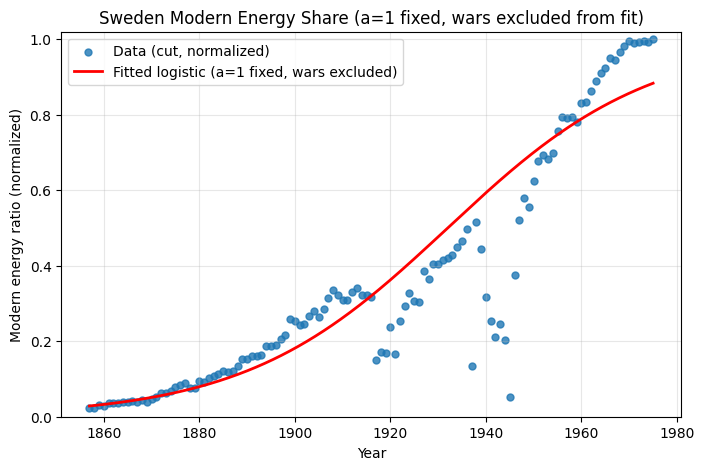


=== Standard logistic parameters (a=1, standard form y=1/[1+exp(-k(x-m))]) ===
k = 0.047113
m = 1931.98


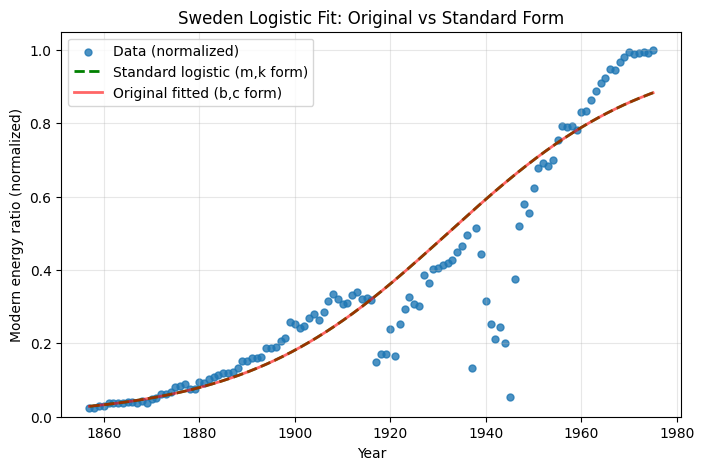

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t

# years_cut, vals_cut がすでに定義されている前提
EPS_LOW, EPS_HIGH = 1e-4, 1-1e-4
ALPHA = 0.05

years_all = years_cut
vals_all  = vals_cut

# --- 1) 戦争期間を除外 ---
war_mask = (
    ((years_all >= 1914) & (years_all <= 1923)) |
    ((years_all >= 1939) & (years_all <= 1948))
)
fit_mask = ~war_mask
years_fit = years_all[fit_mask]
vals_fit  = vals_all[fit_mask]

print(f"Total points after early-cut: {len(years_all)}")
print(f"Used for fit (excluding wars): {len(years_fit)}")
print(f"Fit range: {years_fit.min():.0f}–{years_fit.max():.0f}")

# --- 2) a=1固定のロジスティック関数 ---
def model_func_fixed(x, b, c):
    x = np.asarray(x, dtype=float)
    x0 = x.min()
    return 1.0 / (1.0 + b * np.exp(-c * (x - x0)))

# 初期値と境界
p0 = [1.0, 0.03]     # b, c
bounds = ([0.0, 1e-4], [1e6, 1.0])

# フィット実行
popt, pcov = curve_fit(
    model_func_fixed,
    years_fit,
    vals_fit,
    p0=p0,
    bounds=bounds,
    maxfev=200000
)
b, c = popt
perr = np.sqrt(np.diag(pcov))

# --- 3) 導出量と信頼区間 ---
x0 = years_fit.min()
k = c
lnb = np.log(b)
x_star = x0 + lnb / c

dof = max(len(years_fit) - len(popt), 1)
tval = t.ppf(1 - ALPHA/2, dof)

print("\n=== Sweden: Fitted parameters (a=1 fixed, wars excluded) ===")
for name, val, se in zip(["b","c"], popt, perr):
    ci_low  = val - tval * se
    ci_high = val + tval * se
    print(f"{name} = {val:.6g}  (SE={se:.3g}, 95% CI [{ci_low:.6g}, {ci_high:.6g}])")

print(f"\nk = {k:.6f},  x* = {x_star:.2f}")

# --- 4) プロット ---
t_grid = np.linspace(years_all.min(), years_all.max(), 600)
yhat = model_func_fixed(t_grid, *popt)

plt.figure(figsize=(8,5))
plt.scatter(years_all, vals_all, s=25, alpha=0.8, label="Data (cut, normalized)")
plt.plot(t_grid, yhat, "r-", lw=2, label="Fitted logistic (a=1 fixed, wars excluded)")
plt.xlabel("Year")
plt.ylabel("Modern energy ratio (normalized)")
plt.title("Sweden Modern Energy Share (a=1 fixed, wars excluded from fit)")
plt.ylim(0, 1.02)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


# --- 5) 標準ロジスティック形（m, k形式）への変換 ---

# k = c, m = x0 + ln(b)/c
k_std = c
m_std = x0 + np.log(b) / c

print("\n=== Standard logistic parameters (a=1, standard form y=1/[1+exp(-k(x-m))]) ===")
print(f"k = {k_std:.6f}")
print(f"m = {m_std:.2f}")

# --- 標準形関数定義 ---
def logistic_standard(x, k, m):
    return 1.0 / (1.0 + np.exp(-k * (x - m)))

# --- 確認用プロット ---
yhat_std = logistic_standard(t_grid, k_std, m_std)

plt.figure(figsize=(8,5))
plt.scatter(years_all, vals_all, s=25, alpha=0.8, label="Data (normalized)")
plt.plot(t_grid, yhat_std, "g--", lw=2, label="Standard logistic (m,k form)")
plt.plot(t_grid, yhat, "r-", lw=2, alpha=0.6, label="Original fitted (b,c form)")
plt.xlabel("Year")
plt.ylabel("Modern energy ratio (normalized)")
plt.title("Sweden Logistic Fit: Original vs Standard Form")
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.show()
